# **Import Library**

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

**Load Dataset**

In [105]:
df = pd.read_csv("Electric_Vehicle_Population_Data.csv")
df.shape

(191407, 17)

**Informasi Dataset**

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191407 entries, 0 to 191406
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         191407 non-null  object 
 1   County                                             191403 non-null  object 
 2   City                                               191403 non-null  object 
 3   State                                              191407 non-null  object 
 4   Postal Code                                        191403 non-null  float64
 5   Model Year                                         191407 non-null  int64  
 6   Make                                               191407 non-null  object 
 7   Model                                              191407 non-null  object 
 8   Electric Vehicle Type                              191407 non-null  object

In [108]:
df.describe()

,Postal Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract
count,191403.000000,191407.000000,191407.000000,191407.000000,190993.000000,1.914070e+05,1.914030e+05
mean,98177.823603,2020.732335,55.657442,994.773258,29.016880,2.237202e+08,5.297759e+10
std,2392.808886,2.990487,90.151930,8050.523372,14.909417,7.398058e+07,1.573588e+09
min,1731.000000,1997.000000,0.000000,0.000000,1.000000,4.385000e+03,1.001020e+09
25%,98052.000000,2019.000000,0.000000,0.000000,17.000000,1.861622e+08,5.303301e+10
50%,98125.000000,2022.000000,0.000000,0.000000,33.000000,2.328176e+08,5.303303e+10
75%,98371.000000,2023.000000,72.000000,0.000000,42.000000,2.589708e+08,5.305307e+10
max,99577.000000,2025.000000,337.000000,845000.000000,49.000000,4.792548e+08,5.602100e+10


**Preprocessing yang Dilakukan**

In [109]:
columns_to_drop = [
    'VIN (1-10)', 'County', 'City', 'State', 'Postal Code',
    'Vehicle Location', 'Electric Utility',
    'DOL Vehicle ID', 'Legislative District', '2020 Census Tract'
]

df = df.drop(columns=columns_to_drop, errors='ignore')
df = df.dropna()

df.isnull().sum()

,0
Model Year,0
Make,0
Model,0
Electric Vehicle Type,0
Clean Alternative Fuel Vehicle (CAFV) Eligibility,0
Electric Range,0
Base MSRP,0


# **EXPLORATORY DATA ANALYSIS (EDA)**

**Distribusi Jarak Tempuh**

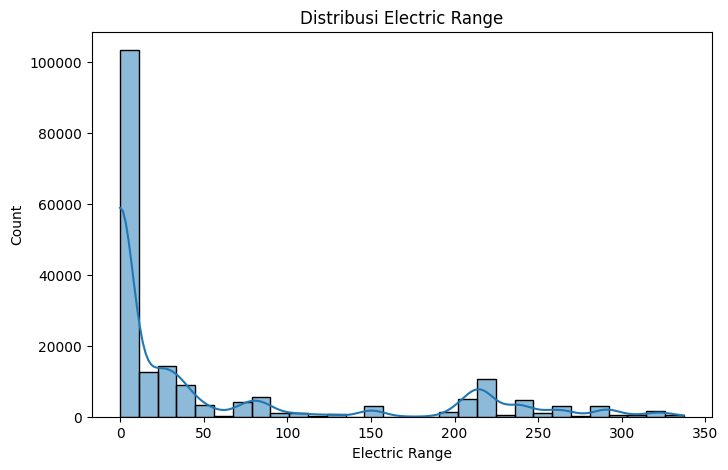

In [110]:
plt.figure(figsize=(8,5))
sns.histplot(df['Electric Range'], bins=30, kde=True)
plt.title("Distribusi Electric Range")
plt.show()

**Hubungan Harga dan Jarak Tempuh**

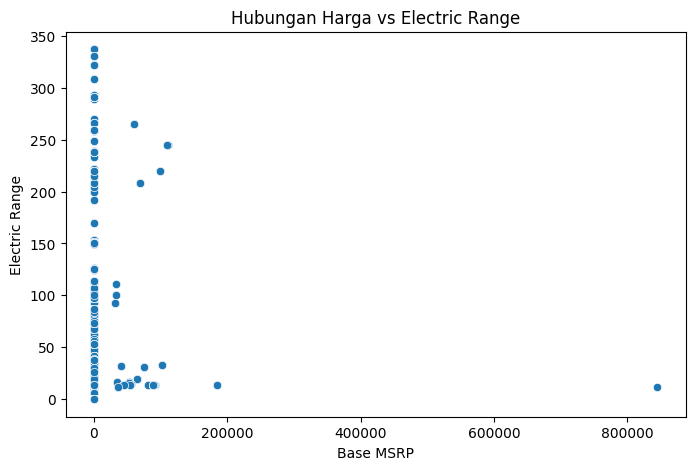

In [111]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Base MSRP', y='Electric Range', data=df)
plt.title("Hubungan Harga vs Electric Range")
plt.show()

**Korelasi Fitur Numerik**

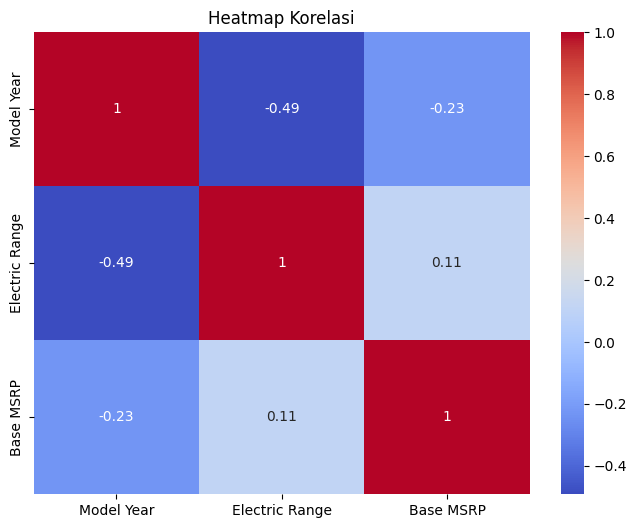

In [112]:
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi")
plt.show()

# **SELEKSI FITUR**

**Encoding Data Kategorik**

In [113]:
label_encoders = {}
categorical_cols = ['Make', 'Model', 'Electric Vehicle Type',
                    'Clean Alternative Fuel Vehicle (CAFV) Eligibility']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

**Pemilihan Fitur**

In [114]:
X = df.drop('Electric Range', axis=1)
y = df['Electric Range']

**Feature Importance (Random Forest)**

In [115]:
rf_temp = RandomForestRegressor(random_state=42)
rf_temp.fit(X, y)

feature_importance = pd.Series(
    rf_temp.feature_importances_, index=X.columns
).sort_values(ascending=False)

feature_importance

,0
Clean Alternative Fuel Vehicle (CAFV) Eligibility,0.605367
Electric Vehicle Type,0.229540
Model Year,0.094716
Make,0.053193
Model,0.016026
Base MSRP,0.001159


# **MODELING**

**Split Data**

In [116]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Normalisasi**

In [117]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Training Model**

**Linear Regression (Baseline)**

In [118]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

**Random Forest Regression**

In [119]:
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

**Simpan Model**

In [120]:
joblib.dump(rf, "rf_ev_range_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

# **EVALUASI MODEL**

**Evaluasi Linear Regression**

In [121]:
y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2:", r2_score(y_test, y_pred_lr))

Linear Regression
MAE: 47.504136974254074
RMSE: 61.872510875713424
R2: 0.5262590317236868


**Evaluasi Random Forest**

In [122]:
y_pred_rf = rf.predict(X_test)

print("Random Forest Regression")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

Random Forest Regression
MAE: 0.6243007245928333
RMSE: 4.131546585825954
R2: 0.9978876262101891
